In [1]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

data = pd.read_csv(url,sep=';')


In [3]:
data = data[data['total sulfur dioxide']<200] # dropping some outliers

### z-score all variables except for quality

# find the columns we want to normalize (all except quality)
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

data['boolQuality'] = 0
data['boolQuality'][data['quality']>5] = 1
data.describe()

/var/folders/sb/75v06dpj77ldyknd005qr5kw0000gn/T/ipykernel_37561/3540835393.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['boolQuality'][data['quality']>5] = 1


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,boolQuality
count,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1597.000000,1597.000000
mean,3.559388e-17,1.245786e-16,1.779694e-17,-9.788316e-17,-1.423755e-16,8.898469e-18,-5.339081e-17,-8.361001e-14,3.025479e-16,8.898469e-17,-5.695020e-16,5.634314,0.534126
std,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,0.806630,0.498990
min,-2.136087e+00,-2.280762e+00,-1.391823e+00,-1.169149e+00,-1.604575e+00,-1.422837e+00,-1.262581e+00,-3.546932e+00,-3.709380e+00,-1.937318e+00,-1.899221e+00,3.000000,0.000000
25%,-7.006076e-01,-7.718255e-01,-9.286769e-01,-4.525789e-01,-3.721412e-01,-8.478700e-01,-7.596977e-01,-6.111392e-01,-6.587444e-01,-6.392206e-01,-8.653154e-01,5.000000,0.000000
50%,-2.412541e-01,-4.530063e-02,-5.384522e-02,-2.376079e-01,-1.809014e-01,-1.770746e-01,-2.568145e-01,-6.216372e-04,-9.673073e-03,-2.261897e-01,-2.073755e-01,6.000000,1.000000
75%,5.051954e-01,6.253377e-01,7.695258e-01,4.902022e-02,5.283609e-02,4.937208e-01,4.975104e-01,5.780428e-01,5.744912e-01,4.228588e-01,6.385471e-01,6.000000,1.000000
max,4.352281e+00,5.878672e+00,3.754246e+00,9.292776e+00,1.112349e+01,5.380944e+00,3.734821e+00,3.683719e+00,4.533826e+00,7.916418e+00,4.210221e+00,8.000000,1.000000


In [4]:
# convert from pandas dataframe to tensor
dataT  = torch.tensor( data[cols2zscore].values ).float()
labels = torch.tensor( data['boolQuality'].values ).float()

print( dataT.shape )
print( labels.shape )

# we'll actually need the labels to be a "tensor"
labels = labels[:,None]
print( labels.shape )

torch.Size([1597, 11])
torch.Size([1597])
torch.Size([1597, 1])


In [5]:
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labels)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)
# test_data.tensors[0].shape[0]
def getBatches(batch_size=32):
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_data, batch_size=test_data.__len__())
    return train_loader, test_loader

In [14]:
class modelClass(nn.Module):
    def __init__(self, actFun):
        super().__init__()

        self.input = nn.Linear(11, 16)

        self.bNorm1 = nn.BatchNorm1d(16) # number of units in the layer
        self.hidden1 = nn.Linear(16, 32)

        self.bNorm2 = nn.BatchNorm1d(32) # number of units in the layer
        self.hidden2 = nn.Linear(32, 20)

        self.output = nn.Linear(20, 1)

        self.actFun = actFun

    def forward(self, data, doBN):

        actFun = getattr(torch.nn, self.actFun)

        x = actFun()(self.input(data))

        if(doBN):
            x = self.bNorm1(x)
            x = actFun()(self.hidden1(x))

            x = self.bNorm2(x)
            x = actFun()(self.hidden2(x))
        else:
            x = actFun()(self.hidden1(x))
            x = actFun()(self.hidden2(x))
        
        x = self.output(x)

        return x


In [13]:
test = getattr(torch.nn, 'ReLU')
test

torch.nn.modules.activation.ReLU

In [7]:
def createModel(actfun):
    ANN = modelClass(actFun=actfun)
    
    learningRate = 0.01

    lossFunction = torch.nn.BCEWithLogitsLoss()

    optimizer = torch.optim.SGD(params=ANN.parameters(), lr=learningRate)

    return ANN, lossFunction, optimizer

In [8]:
epochs = 1000
def trainModel(doBN, train_loader, test_loader, ANN, lossFunction, optimizer):
    
    losses = []
    trainAcc = []
    testAcc = []
    for _ in range(epochs):

        batchAcc = []
        batchLoss = []
        for trainX, trainY in train_loader:
            yHat = ANN.forward(trainX, doBN)
            # print(trainY)
            loss = lossFunction(yHat, trainY)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batchAcc.append((torch.mean(((yHat > 0).float() == trainY).float()) * 100).item()) # no sigmoid
            batchLoss.append(loss.item())
        
        trainAcc.append(np.mean(batchAcc))
        losses.append(np.mean(batchLoss))

        testX, testY = next(iter(test_loader))
        with torch.no_grad():
            predLabels = ANN.forward(testX, doBN)
        testAcc.append((torch.mean(((predLabels > 0).float() == testY).float()) * 100).item()) # no sigmoid
    
    return trainAcc, testAcc, losses
        



In [15]:
activation_functions = ['ReLU', 'ReLU6', 'LeakyReLU']

trainByAct = np.zeros((epochs, len(activation_functions)))
testByAct = np.zeros((epochs, len(activation_functions)))

for ai, actfun in enumerate(activation_functions):
    train_loader, test_loader = getBatches()
    ANN, lossFunction, optimizer = createModel(actfun)
    trainByAct[:,ai], testByAct[:,ai], losses = trainModel(False, train_loader, test_loader, ANN, lossFunction, optimizer)

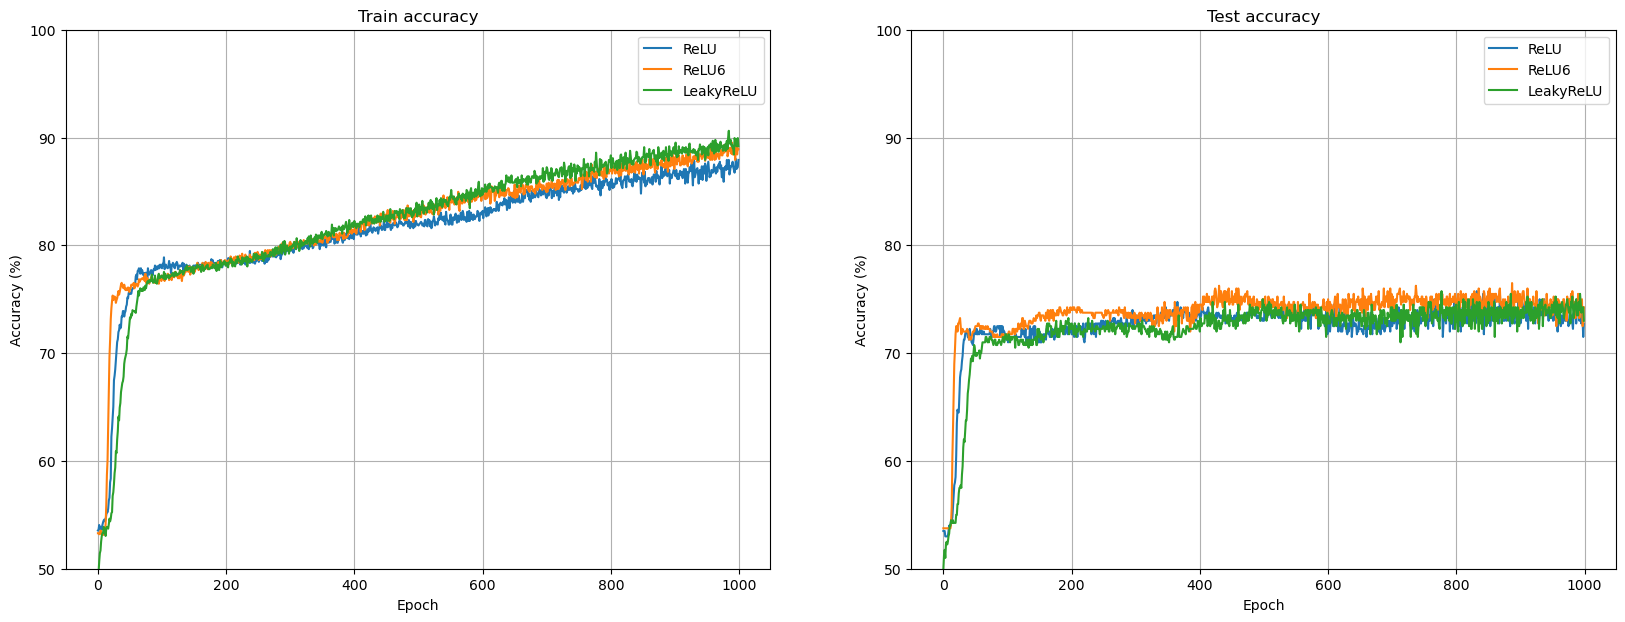

In [16]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(20,7))

ax[0].plot(trainByAct)
ax[0].set_title('Train accuracy')
ax[1].plot(testByAct)
ax[1].set_title('Test accuracy')

# common features
for i in range(2):
  ax[i].legend(activation_functions)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([50,100])
  ax[i].grid()

plt.show()